In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime, os
from sklearn import preprocessing
import numpy as np

#Dividir el DF
from sklearn.model_selection import train_test_split
#Para las redes neuronales

from keras.models import Model, load_model, Sequential
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Bidirectional, GRU, Dense,Dropout
from tensorflow.keras import optimizers

In [2]:
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
SIGNALS = ["body_acc_x_", "body_acc_y_", "body_acc_z_",
           "body_gyro_x_", "body_gyro_y_", "body_gyro_z_",
           "total_acc_x_", "total_acc_y_", "total_acc_z_"]

In [7]:
train_paths = ['/Users/minjeong/Downloads/UCI HAR Dataset-2/train/Inertial Signals/' + signal + 'train.txt' for signal in SIGNALS]
test_paths = ['/Users/minjeong/Downloads/UCI HAR Dataset-2/test/Inertial Signals/' + signal + 'test.txt' for signal in SIGNALS]

In [8]:
def __load_X(X_signal_paths):
    X_signals = []

    for signal_type_path in X_signal_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

In [9]:
x_train = __load_X(train_paths)
x_test = __load_X(test_paths)

In [10]:
x_train = __load_X(train_paths)
x_test = __load_X(test_paths)
y_train = np.loadtxt('/Users/minjeong/Downloads/UCI HAR Dataset-2/train/y_train.txt',  dtype=np.int32)
y_test = np.loadtxt('/Users/minjeong/Downloads/UCI HAR Dataset-2/test/y_test.txt', dtype=np.int32)

In [11]:
print('x_train shape is: ', x_train.shape)
print('x_test shape is: ', x_test.shape)

print('y_train shape is: ', y_train.shape)
print('y_test shape is: ', y_test.shape)

print('Número de clases: ', len(np.unique(y_train)))

x_train shape is:  (7352, 128, 9)
x_test shape is:  (2947, 128, 9)
y_train shape is:  (7352,)
y_test shape is:  (2947,)
Número de clases:  6


In [12]:
print(x_train.shape[1:])
x_train.shape[1]

(128, 9)


128

In [13]:
imput_dim = x_train.shape

In [14]:
input_layer = Input(shape = (imput_dim[1:]))

layer_1 = Bidirectional(GRU(128, activation = 'relu', return_sequences = True,name='encoder_layer_2'))(input_layer)
layer_2 = GRU(50, activation = 'relu', return_sequences = False,name='encoder_layer_3')(layer_1)

layer_3 = RepeatVector(x_train.shape[1],name='repeatVector_layer')(layer_2)

layer_4 = GRU(50, activation = 'relu', return_sequences = True,name='decoder_layer_1')(layer_3)
layer_5 = GRU(128, activation = 'relu', return_sequences = True,name='decoder_layer_2')(layer_4)
output_layer = TimeDistributed(Dense(imput_dim[2]),name='output_layer')(layer_5)

model_GRU = Model(inputs = input_layer , outputs = output_layer)

In [15]:
model_GRU.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 bidirectional (Bidirection  (None, 128, 256)          106752    
 al)                                                             
                                                                 
 encoder_layer_3 (GRU)       (None, 50)                46200     
                                                                 
 repeatVector_layer (Repeat  (None, 128, 50)           0         
 Vector)                                                         
                                                                 
 decoder_layer_1 (GRU)       (None, 128, 50)           15300     
                                                                 
 decoder_layer_2 (GRU)       (None, 128, 128)          69120 

In [16]:
encoder_GRU = Model(inputs = input_layer , outputs = layer_2)

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=50)
model_GRU.compile(optimizer='adam', loss='mse',metrics=['mae', 'mse'])

In [18]:
encoder_decoder_history = model_GRU.fit(x_train, x_train, 
                                              batch_size=512, 
                                              epochs=100,
                                              validation_data=(x_test, x_test),
                                              callbacks=[early_stop])

Epoch 1/100
15/15 [==============================] - 25s 2s/step - loss: 0.1262 - mae: 0.2169 - mse: 0.1262 - val_loss: 0.0744 - val_mae: 0.1649 - val_mse: 0.0744
Epoch 2/100
15/15 [==============================] - 25s 2s/step - loss: 0.0745 - mae: 0.1680 - mse: 0.0745 - val_loss: 0.0613 - val_mae: 0.1476 - val_mse: 0.0613
Epoch 3/100
15/15 [==============================] - 24s 2s/step - loss: 0.0647 - mae: 0.1465 - mse: 0.0647 - val_loss: 0.0581 - val_mae: 0.1383 - val_mse: 0.0581
Epoch 4/100
15/15 [==============================] - 25s 2s/step - loss: 0.0611 - mae: 0.1360 - mse: 0.0611 - val_loss: 0.0549 - val_mae: 0.1315 - val_mse: 0.0549
Epoch 5/100
15/15 [==============================] - 25s 2s/step - loss: 0.0582 - mae: 0.1286 - mse: 0.0582 - val_loss: 0.0520 - val_mae: 0.1233 - val_mse: 0.0520
Epoch 6/100
15/15 [==============================] - 26s 2s/step - loss: 0.0566 - mae: 0.1216 - mse: 0.0566 - val_loss: 0.0507 - val_mae: 0.1195 - val_mse: 0.0507
Epoch 7/100
15/15 [===

In [19]:
X_train = encoder_GRU(x_train)
X_test = encoder_GRU(x_test)

In [20]:
print('Encoded X_train shape is: ', X_train.shape)
print('Encoded X_test shape is: ', X_test.shape)

Encoded X_train shape is:  (7352, 50)
Encoded X_test shape is:  (2947, 50)


In [22]:
from sklearn.ensemble import RandomForestClassifier

def rf(x_train, y_train, n_estimators=300):
 rndforest = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
 rndforest.fit(x_train, y_train)
 return rndforest 

In [23]:
random_forest_en = rf(X_train,y_train, n_estimators=300)

In [24]:
print("Training accuracy:", random_forest_en.score(X_train, y_train))
print("Validation accuracy", random_forest_en.score(X_test, y_test))

Training accuracy: 1.0
Validation accuracy 0.8781812012215813


In [25]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(model, X, y, class_names, file_name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    y_pred = model.predict(X)
    # Compute confusion matrix
    cnf_matrix  = confusion_matrix(y, y_pred)
    np.set_printoptions(precision=1)
    plt.figure(figsize=(18, 16))

    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("MATRIZ DE CONFUSIÓN")
    else:
        print('MATRIZ DE CONFUSIÓN')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title('MATRIZ DE CONFUSIÓN')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('ACCIONES (CLASES)')
    plt.xlabel('CLASE PREDICHA')
    plt.tight_layout()
    plt.savefig(file_name+'.png')
    plt.show()

MATRIZ DE CONFUSIÓN


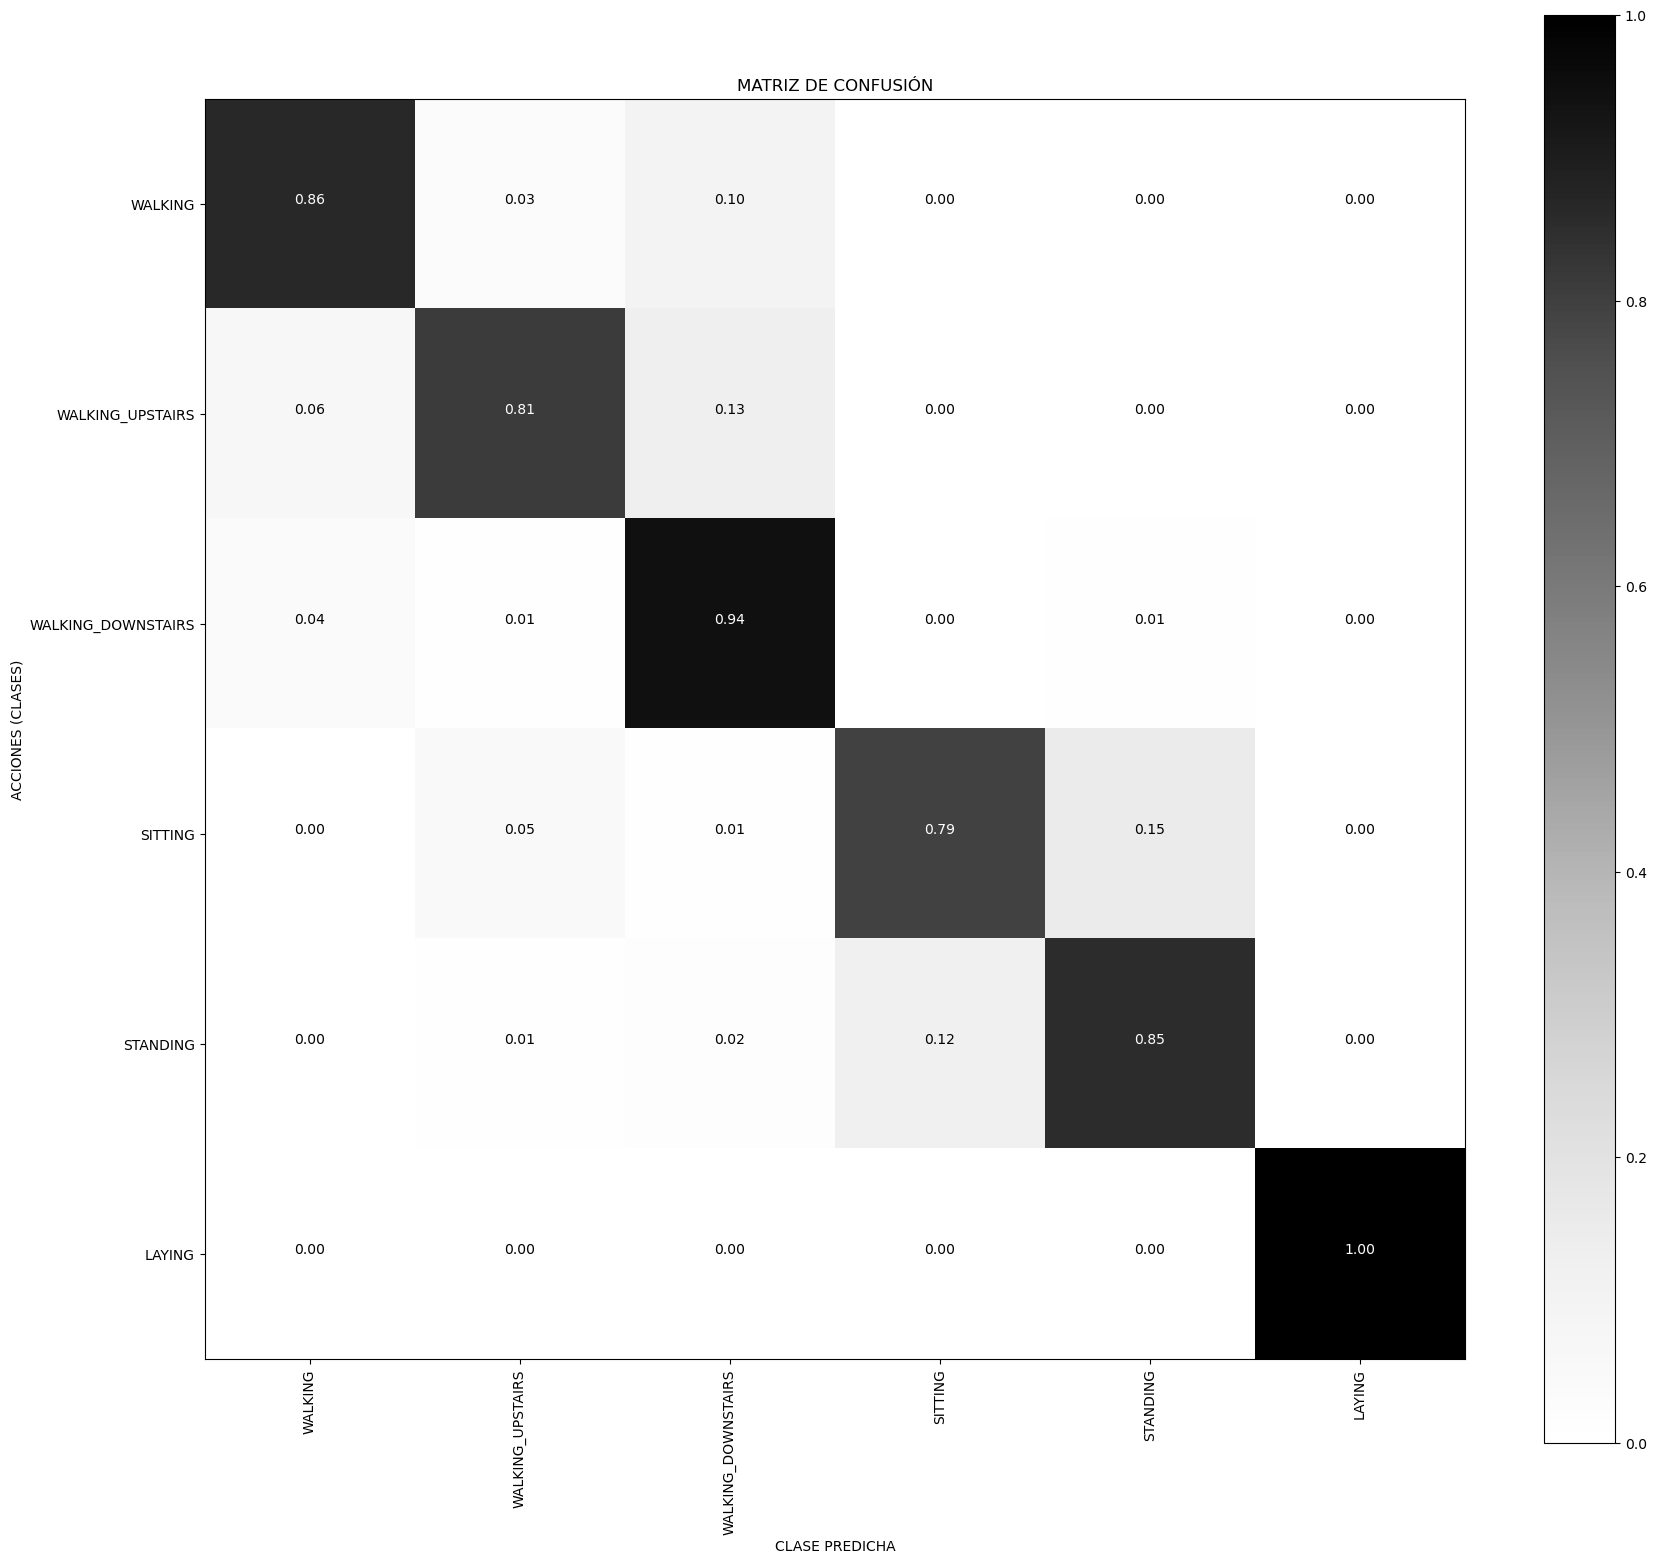

In [26]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(random_forest_en, X_test, y_test, class_names=LABELS, file_name='ConfussionMatrix', normalize=True)